<a href="https://colab.research.google.com/github/chu817/Big-Data-Analytics/blob/main/DataQuest_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
from collections import defaultdict
import random
import dlib
import numpy as np
from skimage.metrics import structural_similarity as ssim


In [14]:
base_path = '/content/drive/MyDrive/Dataquest -Data/output'

# We gotta find the structure of the dataset here
def get_image_paths_by_number(base_path):
    actor_image_paths = defaultdict(list)
    for actor in os.listdir(base_path):
        actor_folder = os.path.join(base_path, actor)
        if os.path.isdir(actor_folder):
            for img_file in os.listdir(actor_folder):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    actor_image_paths[actor].append(os.path.join(actor_folder, img_file))
    return actor_image_paths

In [15]:
#geetting the images
actor_images = get_image_paths_by_number(base_path)

In [16]:
#How many images are there for ech actor + total no. of actors
print(f"Number of classes: {len(actor_images)}")

for actor, images in actor_images.items():
    print(f"{actor}: {len(images)} images")

Number of classes: 30
30: 50 images
29: 50 images
3: 48 images
2: 288 images
1: 96 images
4: 282 images
5: 83 images
9: 524 images
8: 54 images
11: 95 images
12: 172 images
13: 82 images
15: 81 images
14: 293 images
17: 79 images
16: 166 images
18: 44 images
19: 297 images
20: 92 images
10: 307 images
28: 200 images
27: 80 images
26: 80 images
23: 276 images
22: 346 images
25: 159 images
24: 358 images
21: 310 images
7: 292 images
6: 213 images


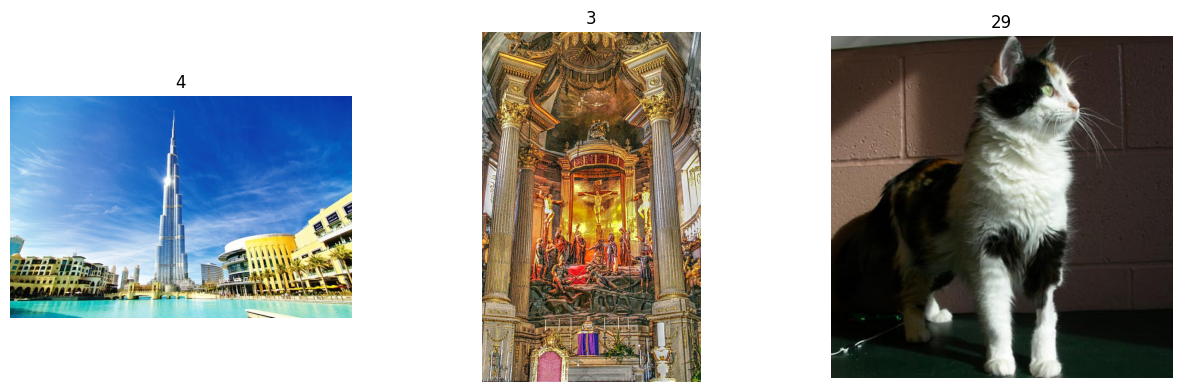

In [7]:
#1. Display som random images of actors
def display_random_actor_images(actor_images, num_images=6):
    random_actors = random.sample(list(actor_images.keys()), num_images // 2)
    plt.figure(figsize=(15, 10))
    for i, actor in enumerate(random_actors):
        random_image = random.choice(actor_images[actor])
        img = Image.open(random_image)
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(img)
        plt.title(actor)
        plt.axis('off')
    plt.show()

display_random_actor_images(actor_images)


<ipython-input-8-b40892c35cc0>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=actor_df.sort_values('Number of Images', ascending=False), x='Number of Images', y='Actor', palette='magma')


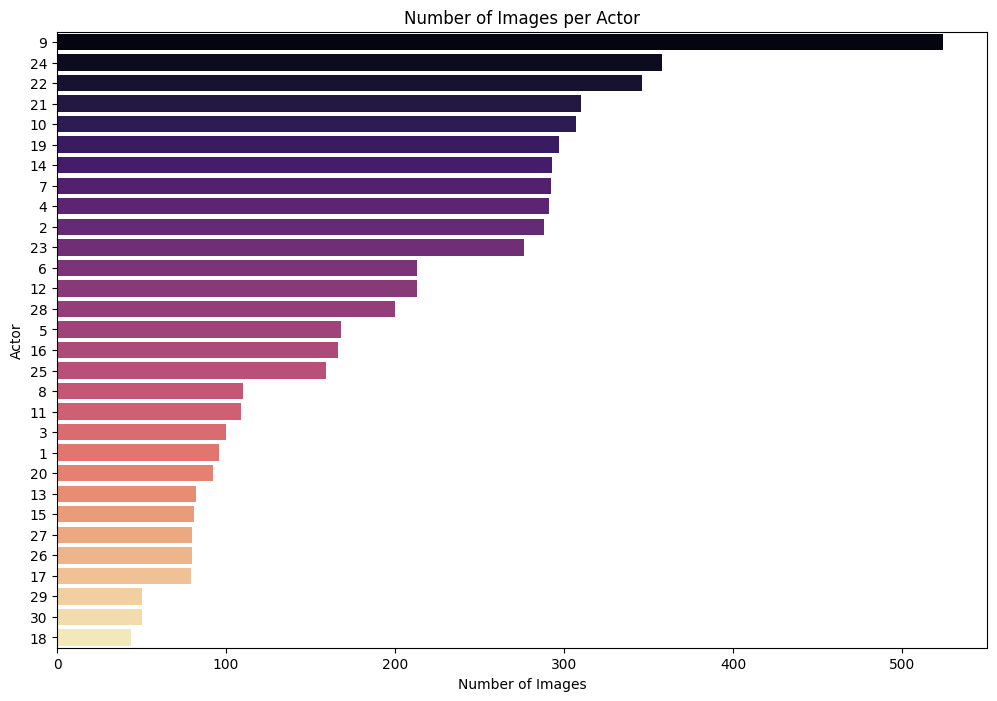

In [8]:
#2.Distribution of images per actor (We find that the distribution is uniform)
actor_counts = {actor: len(images) for actor, images in actor_images.items()}
actor_df = pd.DataFrame(list(actor_counts.items()), columns=['Actor', 'Number of Images'])

# Plotting it
plt.figure(figsize=(12, 8))
sns.barplot(data=actor_df.sort_values('Number of Images', ascending=False), x='Number of Images', y='Actor', palette='magma')
plt.title('Number of Images per Actor')
plt.show()

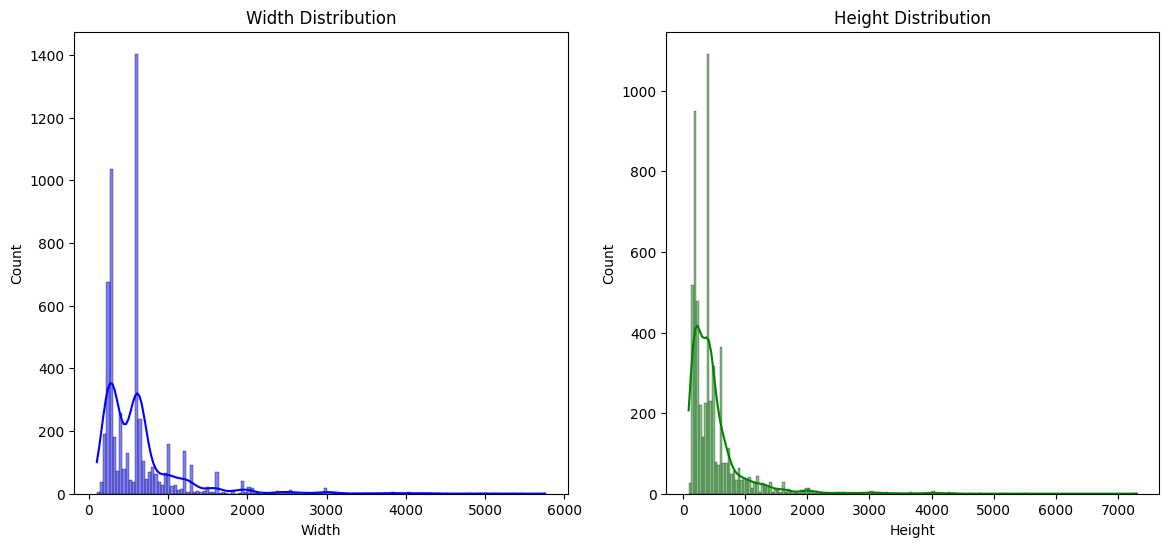

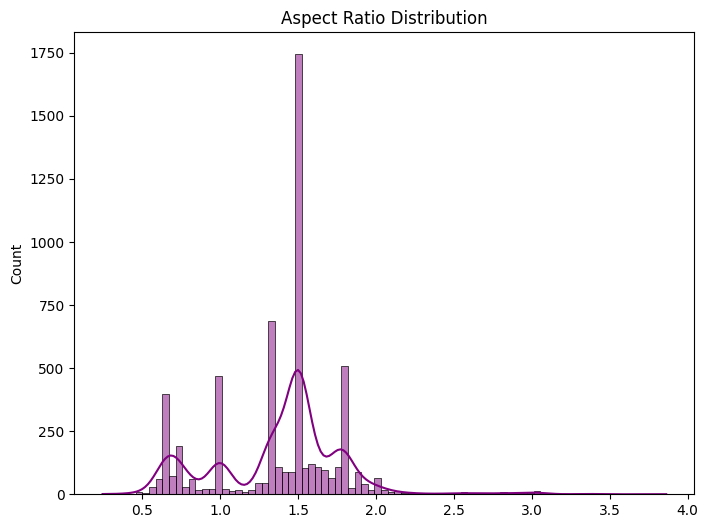

In [9]:
### 3. Image Dimensions and Aspect Ratios
image_dims = []
aspect_ratios = []

for actor, images in actor_images.items():
    for img_path in images:
        img = Image.open(img_path)
        width, height = img.size
        image_dims.append((width, height))
        aspect_ratios.append(width / height)

dims_df = pd.DataFrame(image_dims, columns=['Width', 'Height'])

# Plot width and height distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(dims_df['Width'], kde=True, color='blue')
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dims_df['Height'], kde=True, color='green')
plt.title('Height Distribution')
plt.show()

# Aspect Ratio Distribution
plt.figure(figsize=(8, 6))
sns.histplot(aspect_ratios, kde=True, color='purple')
plt.title('Aspect Ratio Distribution')
plt.show()

In [10]:

### 4. Color Distribution Analysis (RGB Histograms)
def plot_color_histogram(image_path):
    img = cv2.imread(image_path)
    color = ('b', 'g', 'r')
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title(f'Color Histogram: {os.path.basename(image_path)}')
    plt.show()

# Plot color histograms for a few random images
for actor in random.sample(actor_images.keys(), 3):
    random_image = random.choice(actor_images[actor])
    plot_color_histogram(random_image)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
# 5. We have to check for Corrupt Images
def check_corrupt_images(actor_images):
    corrupt_images = []
    for actor, images in actor_images.items():
        for img_path in images:
            try:
                img = Image.open(img_path)
                img.verify()
            except Exception as e:
                corrupt_images.append(img_path)
    return corrupt_images

corrupt_images = check_corrupt_images(actor_images)
print(f"Number of corrupt images: {len(corrupt_images)}")

In [ ]:
# 6. Word Cloud (but like not much point)
from wordcloud import WordCloud

actor_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(actor_counts)

plt.figure(figsize=(10, 8))
plt.imshow(actor_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Actor Distribution Word Cloud')
plt.show()

In [ ]:
# 6. Occlusion Detection - Detect if faces are occluded by objects like glasses, hats, etc.
def detect_occlusion(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return False
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        # Detecting glasses (simple heuristic based on pixel color in the eye area)
        glasses_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')
        eyes = glasses_cascade.detectMultiScale(face)
        if len(eyes) > 0:
            return True  # Glasses detected
    return False

# Example: Check occlusion for images
occlusion_detected = []
for actor, images in actor_images.items():
    for img_path in images:
        if detect_occlusion(img_path):
            occlusion_detected.append(img_path)
print(f"Occluded images (with glasses or hats): {len(occlusion_detected)}")

In [ ]:
# 7. Checking the lighting condition (brightness and variance)
def calculate_brightness(image):
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    return np.mean(image)

brightness_values = []
for actor, images in actor_images.items():
    for img_path in images:
        brightness = calculate_brightness(img_path)
        brightness_values.append(brightness)

# Plot brightness distribution
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=30, color='orange')
plt.title('Brightness Distribution of Images')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def estimate_pose(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        landmarks = predictor(gray, faces[0])
        # Get key landmark points for the face
        nose_tip = (landmarks.part(30).x, landmarks.part(30).y)
        chin = (landmarks.part(8).x, landmarks.part(8).y)
        left_eye = (landmarks.part(36).x, landmarks.part(36).y)
        right_eye = (landmarks.part(45).x, landmarks.part(45).y)
        # Using points to estimate angles
        return True, nose_tip, chin, left_eye, right_eye
    return False, None, None, None, None

# Example: Check pose estimation for a few images
for actor in random.sample(actor_images.keys(), 3):
    random_image = random.choice(actor_images[actor])
    pose_detected, nose_tip, chin, left_eye, right_eye = estimate_pose(random_image)
    if pose_detected:
        print(f"Pose detected for {random_image}")


In [ ]:
# 9. Detecting Blurriness - Laplacian variance method
def is_image_blurry(image_path, threshold=100):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

blurry_images = []
for actor, images in actor_images.items():
    for img_path in images:
        if is_image_blurry(img_path):
            blurry_images.append(img_path)

print(f"Number of blurry images: {len(blurry_images)}")


Number of blurry images: 1083


In [ ]:
# 10. Duplicate Image Detection
def detect_duplicates(image_paths):
    duplicates = []
    image_hashes = {}

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_hash = hash(img.tostring())
        if img_hash in image_hashes:
            similarity = ssim(img, image_hashes[img_hash])
            if similarity > 0.9:
                duplicates.append(img_path)
        else:
            image_hashes[img_hash] = img
    return duplicates

duplicate_images = []
for actor, images in actor_images.items():
    duplicates = detect_duplicates(images)
    if duplicates:
        duplicate_images.extend(duplicates)

print(f"Number of duplicate images: {len(duplicate_images)}")


<ipython-input-75-db9939f164cc>:8: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img_hash = hash(img.tostring())


Number of duplicate images: 0
